In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
import joblib
%matplotlib inline

In [3]:
dataset= pd.read_csv(r"data.csv")

## I-Analyser la base:

### 1)Statistique de la base: 

In [4]:
dataset

,Sexe,age,Emploi,Telephone,statut_personnel,mois_pret_duree,historique de credit,but,Prix ( TND),personnes a charge,solde_d'epargne,duree_emploi,taux de versement ( par mois ),autres_debiteurs,Historique residence,propriete,logement,credits_existants,Score
0,Homme,67,employe qualifie,21306316,Celibataire,6,critique,Electronique,2338,1,0,13 ans,4,rien,6 ans,immobilier,propre,2,0
1,Femme,22,employe qualifie,29241770,NaN,48,rembourse,Electronique,1190,1,890,2 annees,2,rien,5 mois,immobilier,propre,1,1
2,Homme,45,employe qualifie,20505876,Celibataire,42,rembourse,meubles,15764,2,90,5 annees,2,garant,13 ans,l'epargne de la societe de construction,gratuitement,1,0
3,Homme,35,resident non qualifie,24268700,Celibataire,36,rembourse,education,18110,2,0,2 annees,2,rien,8 annees,inconnu/aucun,gratuitement,1,0
4,Homme,35,independant de gestion,27233723,Celibataire,36,rembourse,voiture (occasion),13896,1,570,2 annees,2,rien,3 mois,autre,louer,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,Homme,29,independant de gestion,24967714,Celibataire,24,rembourse,voiture (occasion),13158,1,210,NaN,4,rien,10 mois,inconnu/aucun,gratuitement,1,0
4244,Homme,48,resident non qualifie,27697199,Celibataire,24,critique,Electronique,3486,1,400,13 ans,4,rien,4 mois,l'epargne de la societe de construction,propre,2,0
4245,Homme,50,employe qualifie,23616215,Celibataire,12,rembourse,voiture (neuve),4780,1,0,17 ans,4,rien,1 ans,autre,propre,1,0
4246,Homme,38,employe qualifie,24888543,Celibataire,12,rembourse,Electronique,1608,1,440,13 ans,4,rien,16 ans,autre,propre,1,0


In [5]:
dataset.drop(columns=['Telephone'], inplace=True)

In [6]:
dataset.isna().sum()

Sexe                                  0
age                                   0
Emploi                                0
statut_personnel                   1260
mois_pret_duree                       0
historique de credit                  0
but                                   0
Prix ( TND)                           0
personnes a charge                    0
solde_d'epargne                       0
duree_emploi                        282
taux de versement ( par mois )        0
autres_debiteurs                      0
Historique residence                522
propriete                             0
logement                              0
credits_existants                     0
Score                                 0
dtype: int64

In [7]:
dataset.shape

(4248, 18)

C:\Users\ALI\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Score', ylabel='count'>

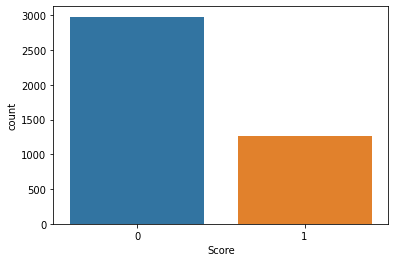

In [8]:
sns.countplot(dataset.Score)

In [9]:
dataset['Score'].value_counts()

Score
0    2982
1    1266
Name: count, dtype: int64

In [10]:
dataset['Sexe'].value_counts()

Sexe
Homme    2988
Femme    1260
Name: count, dtype: int64

In [11]:
dataset['credits_existants'].value_counts()

credits_existants
1    2646
2    1440
3     126
4      36
Name: count, dtype: int64

In [12]:
(dataset['age']).describe()

count    4248.000000
mean       35.877119
std        11.549729
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: age, dtype: float64

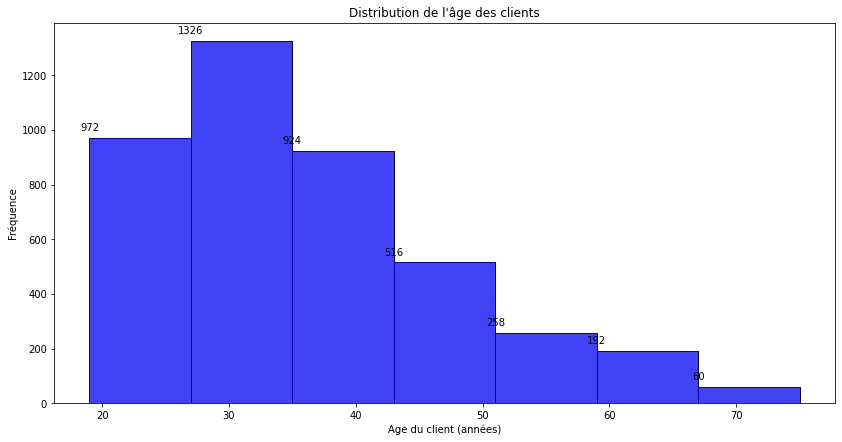

In [13]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.histplot(dataset['age'], bins=7, kde=False, color='lightgray', ax=ax)
counts, bins, patches = ax.hist(dataset['age'], bins=7, color='blue', alpha=0.7)
for count, bin, patch in zip(counts, bins, patches):
    height = patch.get_height()
    ax.annotate(f'{int(count)}', xy=(bin, height), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

plt.xlabel("Age du client (années)")
plt.ylabel("Fréquence")
plt.title("Distribution de l'âge des clients")
plt.show()

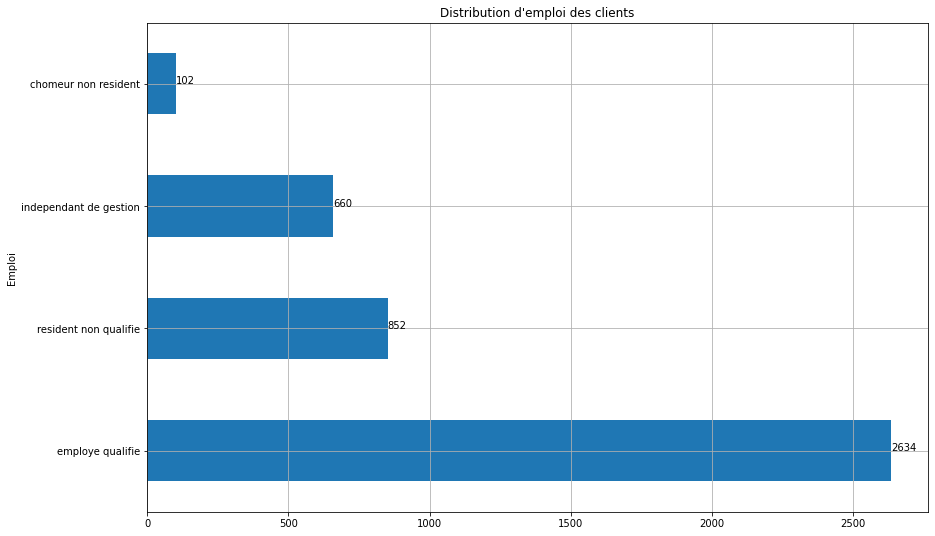

In [14]:
plt.figure(figsize = (14, 9))

ax = dataset['Emploi'].value_counts().plot(kind='barh')
for index, value in enumerate(dataset['Emploi'].value_counts()):
    ax.text(value, index, str(value))
plt.title("Distribution d'emploi des clients")
plt.grid()

In [15]:
dataset['statut_personnel'].value_counts()

statut_personnel
Celibataire    2406
marie           384
divorce         198
Name: count, dtype: int64

### Analyser les valeurs NAN:

In [16]:
def missing_columns(dataframe):
    """
    Returns a dataframe that contains missing column names and 
    percent of missing values in relation to the whole dataframe.
    
    dataframe: dataframe that gives the column names and their % of missing values
    """
    
    # find the missing values
    missing_values = dataframe.isnull().sum().sort_values(ascending=False)
    
    # percentage of missing values in relation to the overall size
    missing_values_pct = 100 * missing_values/len(dataframe)
    
    # create a new dataframe which is a concatinated version
    concat_values = pd.concat([missing_values, missing_values/len(dataframe),missing_values_pct.round(1)],axis=1)

    # give new col names
    concat_values.columns = ['Missing Count','Missing Count Ratio','Missing Count %']
    
    # return the required values
    return concat_values[concat_values.iloc[:,1]!=0]
missing_columns(dataset)

,Missing Count,Missing Count Ratio,Missing Count %
statut_personnel,1260,0.296610,29.7
Historique residence,522,0.122881,12.3
duree_emploi,282,0.066384,6.6


<Axes: >

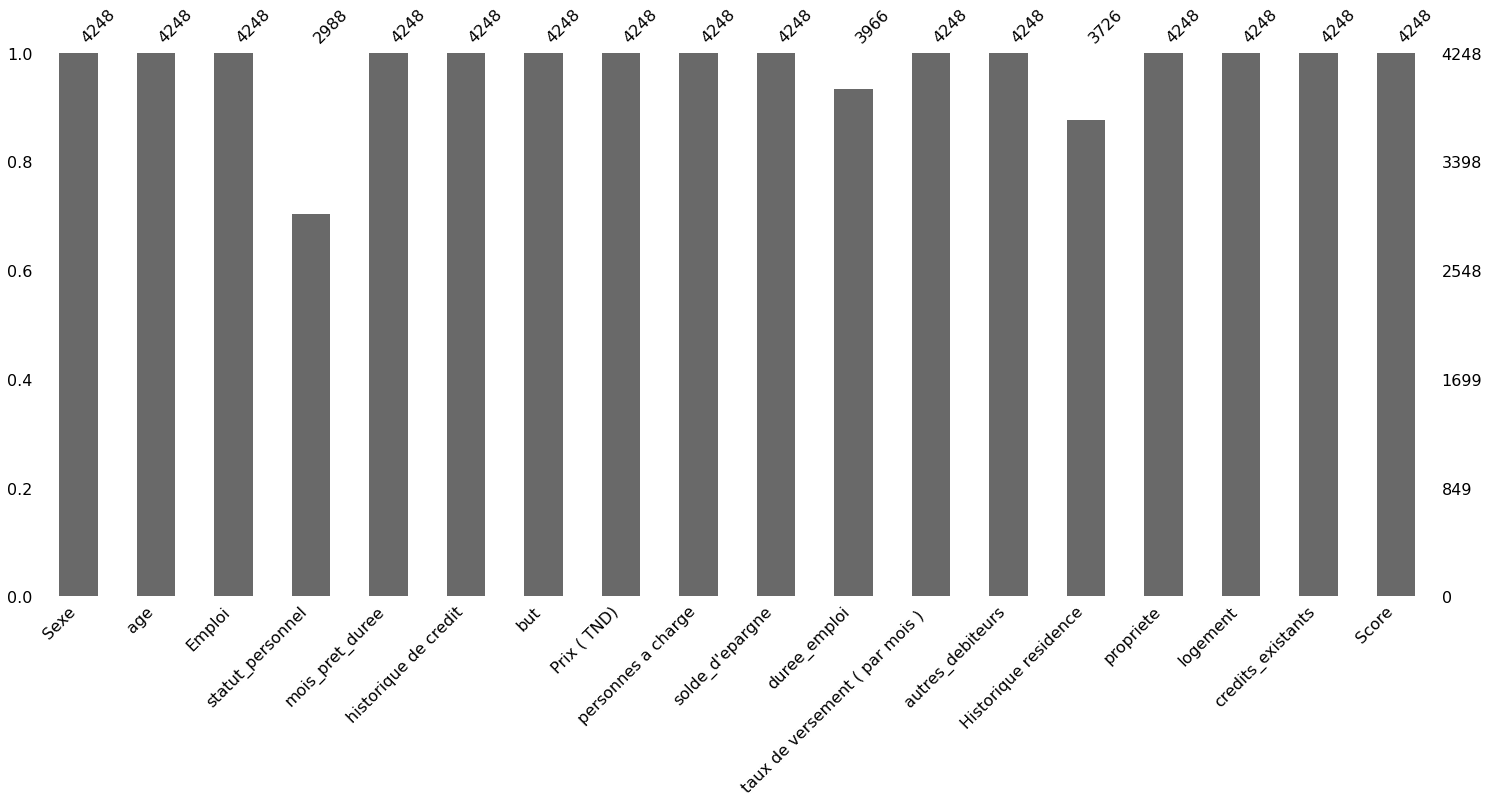

In [17]:
msno.bar(dataset)

<Axes: >

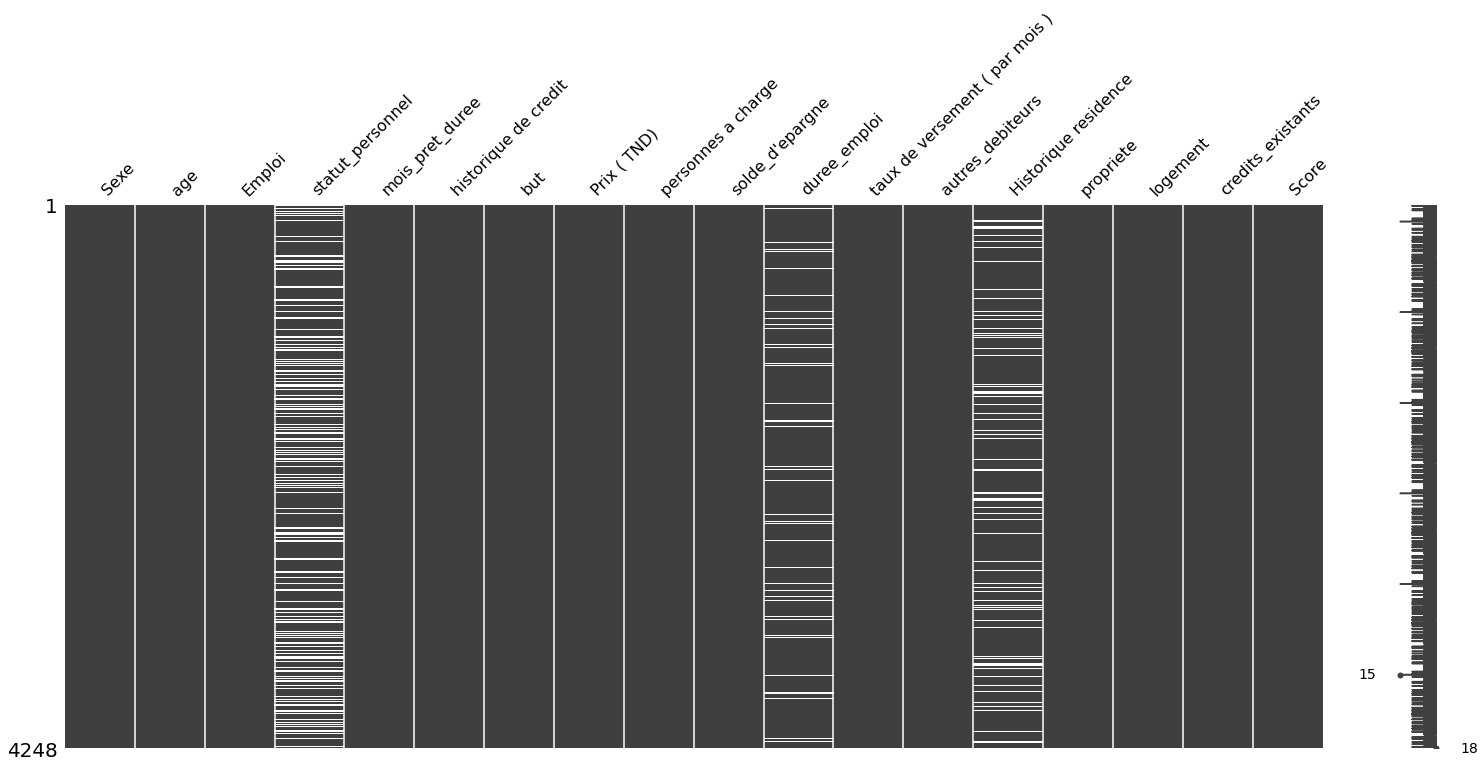

In [18]:
msno.matrix(dataset)

## Les valeurs uniques:

In [19]:
def unique_classes(dataframe):
    output = pd.DataFrame()
    output.index = pd.DataFrame(dataframe.select_dtypes('object').apply(pd.Series.nunique)).index
    output['Number cat'] = dataframe.select_dtypes('object').apply(pd.Series.nunique).values
    output['Categorical values'] = dataframe.select_dtypes('object').apply(pd.Series.unique).values
    pd.set_option('display.max_colwidth', None)
    return output
unique_classes(dataset)

,Number cat,Categorical values
Sexe,2,"[Homme, Femme]"
Emploi,4,"[employe qualifie, resident non qualifie, independant de gestion, chomeur non resident]"
statut_personnel,3,"[Celibataire, nan, divorce, marie]"
historique de credit,5,"[critique, rembourse, entierement rembourse, entierement rembourse cette banque, retarde]"
but,10,"[Electronique, meubles, education, voiture (occasion), voiture (neuve), Entreprise, reparations, autres, appareils electromenagers, reconversion]"
duree_emploi,31,"[13 ans, 2 annees, 5 annees, 4 annees, nan, 6 mois, 5 mois, 3 annees, 1 ans, 17 ans, 3 mois, 9 annees, 4 mois, 10 mois, 11 ans, 7 mois, 19 annees, 7 ans, 14 ans, 1 mois, 18 ans, 16 ans, 15 ans, 6 ans, 8 annees, 12 ans, 2 mois, 0 mois, 9 mois, 10 annees, 8 mois, 11 mois]"
autres_debiteurs,3,"[rien, garant, codemandeur]"
Historique residence,36,"[6 ans, 5 mois, 13 ans, 8 annees, 3 mois, 24 ans, 10 mois, nan, 10 annees, 19 annees, 0 mois, 7 ans, 3 annees, 7 mois, 1 ans, 16 ans, 6 mois, 2 annees, 20 ans, 11 mois, 8 mois, 14 ans, 21 ans, 5 annees, 9 mois, 2 mois, 15 ans, 11 ans, 18 ans, 22 ans, 23 annees, 4 mois, 12 ans, 4 annees, 1 mois, 17 ans, 9 annees]"
propriete,4,"[immobilier, l'epargne de la societe de construction, inconnu/aucun, autre]"
logement,3,"[propre, gratuitement, louer]"


In [20]:
dataset.shape

(4248, 18)

### 2)Data Cleaning: 

In [21]:
def transform_year(Dataframe,x):
    y = pd.DataFrame(Dataframe[x]).values.tolist()
    output=[]
    for i in range(Dataframe.shape[0]):
        n = y[i][0]
        if type(n) == float:
            output.append(n)
        else:
            number = [int(temp)for temp in n.split() if temp.isdigit()]
            if("annees" in n) or ("ans" in n):
                output.append(number[0]*12)
            elif ("mois" in n) :
                output.append(number[0])   
            else:
                output.append('nan')            
    return output
dataset["duree_emploi"] = transform_year(dataset,"duree_emploi")

In [22]:
dataset.loc[(dataset.duree_emploi.isnull()), 'duree_emploi']= 0

In [23]:
missing_columns(dataset)

,Missing Count,Missing Count Ratio,Missing Count %
statut_personnel,1260,0.296610,29.7
Historique residence,522,0.122881,12.3


In [24]:
 dataset.loc[(dataset.statut_personnel.isnull()), 'statut_personnel']= 'Celibataire'

In [25]:
dataset["Historique residence"]

0          6 ans
1         5 mois
2         13 ans
3       8 annees
4         3 mois
          ...   
4243     10 mois
4244      4 mois
4245       1 ans
4246      16 ans
4247    8 annees
Name: Historique residence, Length: 4248, dtype: object

In [26]:
dataset["Historique residence"] = transform_year(dataset,"Historique residence")

In [27]:
dataset["Historique residence"] = dataset['Historique residence'].fillna(dataset['Historique residence'].median())

### 3)Data Transformation:

In [28]:
print("dataset: \n{}".format(dataset.dtypes.value_counts()))

dataset: 
object     8
int64      8
float64    2
Name: count, dtype: int64


In [29]:
colonnes_object = dataset.select_dtypes(include=['object']).columns

le = LabelEncoder()

for col in colonnes_object:
    dataset[col] = le.fit_transform(dataset[col])

In [30]:
dataset

,Sexe,age,Emploi,statut_personnel,mois_pret_duree,historique de credit,but,Prix ( TND),personnes a charge,solde_d'epargne,duree_emploi,taux de versement ( par mois ),autres_debiteurs,Historique residence,propriete,logement,credits_existants,Score
0,1,67,1,0,6,0,0,2338,1,0,156.0,4,2,72.0,1,2,2,0
1,0,22,1,0,48,3,0,1190,1,890,24.0,2,2,5.0,1,2,1,1
2,1,45,1,0,42,3,5,15764,2,90,60.0,2,1,156.0,3,0,1,0
3,1,35,3,0,36,3,4,18110,2,0,24.0,2,2,96.0,2,0,1,0
4,1,35,2,0,36,3,9,13896,1,570,24.0,2,2,3.0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,1,29,2,0,24,3,9,13158,1,210,0.0,4,2,10.0,2,0,1,0
4244,1,48,3,0,24,0,0,3486,1,400,156.0,4,2,4.0,3,2,2,0
4245,1,50,1,0,12,3,8,4780,1,0,204.0,4,2,12.0,0,2,1,0
4246,1,38,1,0,12,3,0,1608,1,440,156.0,4,2,192.0,0,2,1,0


In [31]:
dataset.isna().sum()

Sexe                               0
age                                0
Emploi                             0
statut_personnel                   0
mois_pret_duree                    0
historique de credit               0
but                                0
Prix ( TND)                        0
personnes a charge                 0
solde_d'epargne                    0
duree_emploi                       0
taux de versement ( par mois )     0
autres_debiteurs                   0
Historique residence               0
propriete                          0
logement                           0
credits_existants                  0
Score                              0
dtype: int64

In [32]:
for column in dataset.columns:
    unique_values = dataset[column].unique()
    print(f"Valeurs uniques pour la colonne {column}: {unique_values}")

Valeurs uniques pour la colonne Sexe: [1 0]
Valeurs uniques pour la colonne age: [67 22 45 35 61 28 25 24 32 53 31 44 48 26 36 42 34 30 57 37 58 39 23 29
 52 27 50 46 40 66 47 56 54 20 41 63 21 38 70 33 65 68 55 64 51 49 43 60
 19 74 62 75 59]
Valeurs uniques pour la colonne Emploi: [1 3 2 0]
Valeurs uniques pour la colonne statut_personnel: [0 1 2]
Valeurs uniques pour la colonne mois_pret_duree: [ 6 48 42 36 12 30 15 24 10  7 18 45 11 27  9 20 14 33 60 21  8 16  4 13
 39  5 26 72 22 40 28]
Valeurs uniques pour la colonne historique de credit: [0 3 1 2 4]
Valeurs uniques pour la colonne but: [0 5 4 9 8 1 7 3 2 6]
Valeurs uniques pour la colonne Prix ( TND): [ 2338  1190 15764 18110 13896  6118 10468 25900  8616  3134 28060  2564
  4848 16144  6860  5294 44820  3608  4138  2748   818  4830  3826 11732
  2528  9492 12220  4200  4666  2316 12408 12374 12286  2786  4598  2704
 14456  4146 11930  2524  6756  4450  1566  1293  1913  3922 12458  2782
  3074  3906 28842  6362 10380  4342  201

In [33]:
# Renommer les colonnes du nouvel échantillon
dataset.rename(columns={
    'Prix ( TND)': 'Prix',
    'historique de credit': 'historique_credit',
    'taux de versement ( par mois ) ': 'taux_versement_mensuel',
    'solde_d\'epargne': 'solde_epargne',
    'duree_emploi': 'duree_emploi',
    'age': 'age',
    'logement': 'logement',
    'mois_pret_duree': 'mois_pret_duree'
}, inplace=True)

In [34]:
corr_matrix = dataset.corr()

target_corr = corr_matrix[dataset.columns[-1]].sort_values(ascending=False)
print(target_corr)

Score                     1.000000
mois_pret_duree           0.232584
historique_credit         0.118673
Prix                      0.105302
taux_versement_mensuel    0.102838
but                       0.026162
propriete                 0.009649
Emploi                   -0.005006
statut_personnel         -0.005077
Historique residence     -0.005993
autres_debiteurs         -0.043702
credits_existants        -0.048798
personnes a charge       -0.049179
Sexe                     -0.077175
solde_epargne            -0.092722
duree_emploi             -0.099463
age                      -0.102701
logement                 -0.116083
Name: Score, dtype: float64


In [35]:
threshold = 0.09
important_columns = target_corr[target_corr.abs() > threshold].index

In [36]:
important_columns

Index(['Score', 'mois_pret_duree', 'historique_credit', 'Prix',
       'taux_versement_mensuel', 'solde_epargne', 'duree_emploi', 'age',
       'logement'],
      dtype='object')

## II-Modélisation:

In [37]:
X = dataset[important_columns.drop('Score')]
y = dataset['Score']

In [38]:
X

,mois_pret_duree,historique_credit,Prix,taux_versement_mensuel,solde_epargne,duree_emploi,age,logement
0,6,0,2338,4,0,156.0,67,2
1,48,3,1190,2,890,24.0,22,2
2,42,3,15764,2,90,60.0,45,0
3,36,3,18110,2,0,24.0,35,0
4,36,3,13896,2,570,24.0,35,1
...,...,...,...,...,...,...,...,...
4243,24,3,13158,4,210,0.0,29,0
4244,24,0,3486,4,400,156.0,48,2
4245,12,3,4780,4,0,204.0,50,2
4246,12,3,1608,4,440,156.0,38,2


In [40]:
X.to_csv('data_powerBI.csv', index=False)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
models = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=10000),
    "SVM": SVC(random_state=42),
    "KNeighbors": KNeighborsClassifier(),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

In [56]:
results = {}
best_model_name = None
best_accuracy = 0
best_model = None

for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "accuracy": accuracy,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm
    }
    

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
        best_model = model

In [57]:
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print(f"Recall: {metrics['recall']:.2f}")
    print(f"F1 Score: {metrics['f1_score']:.2f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}\n")

Model: LogisticRegression
Accuracy: 0.72
Recall: 0.72
F1 Score: 0.66
Confusion Matrix:
[[574  19]
 [215  42]]

Model: SVM
Accuracy: 0.70
Recall: 0.70
F1 Score: 0.58
Confusion Matrix:
[[593   0]
 [255   2]]

Model: KNeighbors
Accuracy: 0.99
Recall: 0.99
F1 Score: 0.99
Confusion Matrix:
[[593   0]
 [  9 248]]

Model: GradientBoosting
Accuracy: 0.86
Recall: 0.86
F1 Score: 0.85
Confusion Matrix:
[[576  17]
 [101 156]]

Model: AdaBoost
Accuracy: 0.77
Recall: 0.77
F1 Score: 0.76
Confusion Matrix:
[[537  56]
 [137 120]]



### Enregistrer le meilleur modèle (.pkl)

In [58]:
if best_model:
    joblib.dump(best_model, f"{best_model_name}_scoring_clients.pkl")
    print(f"Le meilleur modèle '{best_model_name}' a été enregistré sous le nom '{best_model_name}_scoring_clients.pkl'.")

Le meilleur modèle 'KNeighbors' a été enregistré sous le nom 'KNeighbors_scoring_clients.pkl'.


### Evaluation:

In [67]:
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Accuracy sur l'ensemble d'entraînement: {train_accuracy:.2f}")

Accuracy sur l'ensemble d'entraînement: 1.00


In [71]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X, y, cv=5)
print(f"Accuracy moyenne en validation croisée: {cv_scores.mean():.2f}")
print(f"Écart type des scores de validation croisée: {cv_scores.std():.2f}")

Accuracy moyenne en validation croisée: 1.00
Écart type des scores de validation croisée: 0.00


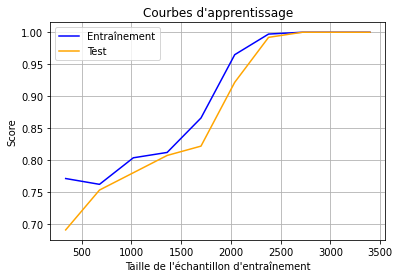

In [69]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Entraînement', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Test', color='orange')
plt.title('Courbes d\'apprentissage')
plt.xlabel('Taille de l\'échantillon d\'entraînement')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

### Test model:

In [59]:
# Load the model from the file
model = joblib.load(f"{best_model_name}_scoring_clients.pkl")

In [3]:
model

KNeighborsClassifier()

In [61]:
for column in X.columns:
    unique_values = X[column].unique()
    print(f'Unique values in {column}:', unique_values)

Unique values in mois_pret_duree: [ 6 48 42 36 12 30 15 24 10  7 18 45 11 27  9 20 14 33 60 21  8 16  4 13
 39  5 26 72 22 40 28]
Unique values in historique_credit: [0 3 1 2 4]
Unique values in Prix: [ 2338  1190 15764 18110 13896  6118 10468 25900  8616  3134 28060  2564
  4848 16144  6860  5294 44820  3608  4138  2748   818  4830  3826 11732
  2528  9492 12220  4200  4666  2316 12408 12374 12286  2786  4598  2704
 14456  4146 11930  2524  6756  4450  1566  1293  1913  3922 12458  2782
  3074  3906 28842  6362 10380  4342  2014  3638  4788 16266  1460  3954
  3052  7930  7664  2426  3510  4630  2824  4498  2216  1236  2818  7234
  2636  4024  5244 14114  2938  4646  1864  3838  4890 12916 12156 15442
  2820  3360  7156  4264  8562  4732  7736  3536  1562  3848  4242  1402
  1278  3720  6998  5416  3968 20288  2480 17226  1532  1418  9590  6832
  4924  4576  7132  1720  3164  2692 15516  2576  5744  2110 14616  5956
  3154  7944  3870  1900  1526  4128  2828 14970  5154   676  3926  1

In [62]:
X.columns

Index(['mois_pret_duree', 'historique_credit', 'Prix',
       'taux_versement_mensuel', 'solde_epargne', 'duree_emploi', 'age',
       'logement'],
      dtype='object')

In [5]:
new_sample = [6, 0, 2338, 4, 0, 150, 40, 2]
print('New sample: {}'.format(new_sample))

column_names = ['mois_pret_duree', 'historique_credit', 'Prix', 'taux_versement_mensuel', 'solde_epargne', 'duree_emploi', 'age', 'logement']  # Remplacez par vos noms de colonnes réels
new_sample_df = pd.DataFrame([new_sample], columns=column_names)

pred = model.predict(new_sample_df)
print('Predicted class is {}'.format(pred[0]))

New sample: [6, 0, 2338, 4, 0, 150, 40, 2]
Predicted class is 0
